**Reading Data**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/infosys-stock-price-nyse/INFY.csv


In [2]:
data=pd.read_csv('/kaggle/input/infosys-stock-price-nyse/INFY.csv',parse_dates=['Date'],index_col='Date')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-30,8.320,8.500,8.225,8.340,7.163630,14280800
2015-12-01,8.350,8.385,8.205,8.280,7.112093,6067200
2015-12-02,8.210,8.225,8.110,8.130,6.983251,6377600
2015-12-03,8.140,8.150,8.035,8.065,6.927418,4031000
2015-12-04,8.065,8.215,8.060,8.185,7.030493,3501200


**Data Preprocessing**

Get the Day and Day of week as features to predict the Closing price of the stock

In [3]:
data['Day']=data.index.day
data['DayOfWeek']=data.index.dayofweek
data.head()

,Open,High,Low,Close,Adj Close,Volume,Day,DayOfWeek
Date,,,,,,,,
2015-11-30,8.320,8.500,8.225,8.340,7.163630,14280800,30,0
2015-12-01,8.350,8.385,8.205,8.280,7.112093,6067200,1,1
2015-12-02,8.210,8.225,8.110,8.130,6.983251,6377600,2,2
2015-12-03,8.140,8.150,8.035,8.065,6.927418,4031000,3,3
2015-12-04,8.065,8.215,8.060,8.185,7.030493,3501200,4,4


Plot of the target variable , i.e Close Price

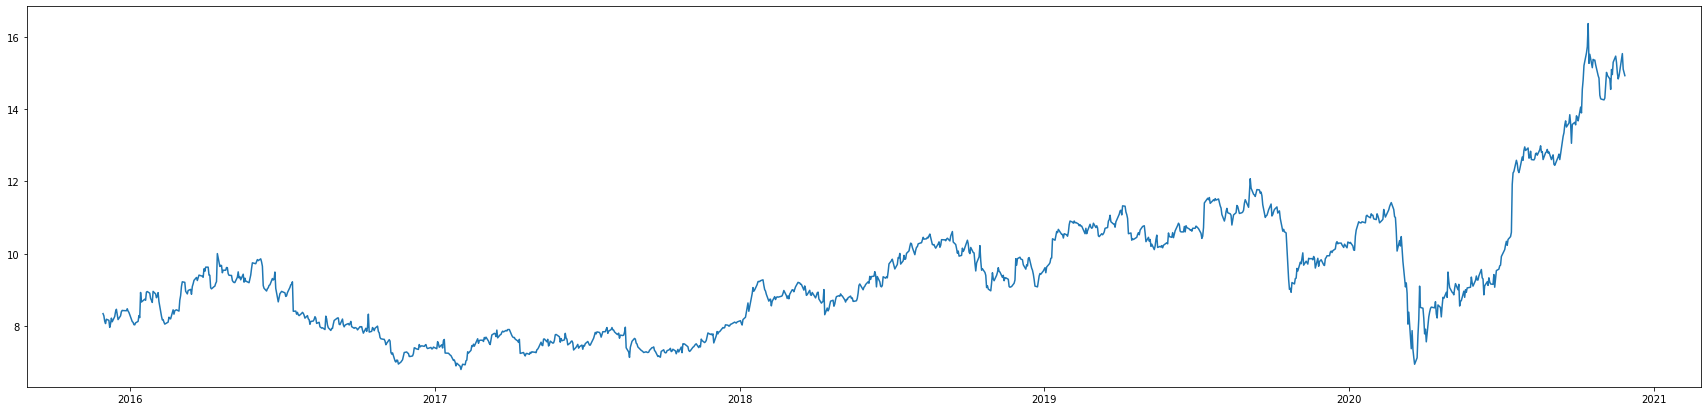

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,7))
plt.plot(data.index,data['Close'])
plt.show()

We take a 90-10 split of the data, You can experiment with the split size.

In [5]:
train_size=int(len(data)*0.9)
train,test=data.iloc[:train_size],data.iloc[train_size:len(data)]
train.shape,test.shape

((1133, 8), (126, 8))

Since the features are of various numeric ranges, So with MinMax Scaler we get th variables down to range [0,1].

In [6]:
from sklearn.preprocessing import MinMaxScaler

rs_data = MinMaxScaler()
rs_target = MinMaxScaler()

target=data['Close']
data.drop(columns=['Close'],inplace=True)

train.loc[:,data.columns]=rs_data.fit_transform(train.loc[:,data.columns].to_numpy())
train['Close']=rs_target.fit_transform(train[['Close']].to_numpy())
test.loc[:,data.columns]=rs_data.fit_transform(test.loc[:,data.columns].to_numpy())
test['Close']=rs_target.fit_transform(test[['Close']].to_numpy())

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

This is by far the most important snipet of the projct. Here we create the main data., i.e Here we use the previous time stamp data values of the time series as the data and the current time value as target, In the next instance, the current value goes on with the data and the next value is considered as the target.Hope it makes sense ;p.

In [7]:
import numpy as np
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Here we take the past 5 days close price to predict the 6th day close price with all the other parameters of the data too.

In [8]:
time_steps=5

x_train, y_train = create_dataset(train, train['Close'], time_steps)
x_test, y_test = create_dataset(test, test['Close'], time_steps)

x_train.shape,x_test.shape

((1128, 5, 8), (121, 5, 8))

**Model Creation**

The Conv-1D layer is technically added to smooth out the input vector which is our data. This helps the LSTM underneath to preform really well on the smoothened data.

In [9]:
import keras
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,return_sequences=True
    )
  ))
model.add(
  keras.layers.Bidirectional(
  keras.layers.LSTM(
  units=500,return_sequences=True
    )
  ))
model.add(
  keras.layers.Bidirectional(
  keras.layers.LSTM(units=500)
  )
)
model.add(keras.layers.Dropout(rate=0.25))
model.add(keras.layers.Dense(units=100,activation='relu'))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(units=1))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mse"])

**Model Training**

In [10]:
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.35,
    shuffle=False,
    verbose=1
)

Epoch 1/50
23/23 [==============================] - 17s 363ms/step - loss: 0.0162 - mse: 0.0324 - val_loss: 0.0160 - val_mse: 0.0319
Epoch 2/50
23/23 [==============================] - 6s 252ms/step - loss: 0.0109 - mse: 0.0218 - val_loss: 0.0089 - val_mse: 0.0179
Epoch 3/50
23/23 [==============================] - 6s 266ms/step - loss: 0.0101 - mse: 0.0201 - val_loss: 0.0170 - val_mse: 0.0340
Epoch 4/50
23/23 [==============================] - 6s 249ms/step - loss: 0.0075 - mse: 0.0151 - val_loss: 0.0247 - val_mse: 0.0494
Epoch 5/50
23/23 [==============================] - 6s 255ms/step - loss: 0.0087 - mse: 0.0175 - val_loss: 0.0060 - val_mse: 0.0121
Epoch 6/50
23/23 [==============================] - 6s 254ms/step - loss: 0.0094 - mse: 0.0187 - val_loss: 0.0119 - val_mse: 0.0238
Epoch 7/50
23/23 [==============================] - 6s 263ms/step - loss: 0.0120 - mse: 0.0240 - val_loss: 0.0061 - val_mse: 0.0123
Epoch 8/50
23/23 [==============================] - 6s 266ms/step - loss: 0

Since we had scaled the values previously, Now to compare with the actual values and also get correct predictions we have to scale them back to their original range.

In [11]:
pred=model.predict(x_test)
y_train_inv=rs_target.inverse_transform(y_train.reshape(1,-1))
y_test_inv=rs_target.inverse_transform(y_test.reshape(1,-1))
pred=rs_target.inverse_transform(pred.reshape(1,-1))

**Visualizations**

Although the plot looks pretty satisfactory, I still feel there is room for plenty of improvement, Can try with tweaking the hyperparameters such as timesteps and also the train-test-split values. Try it out and also please upvote this notebook if this has been a good learning experience.

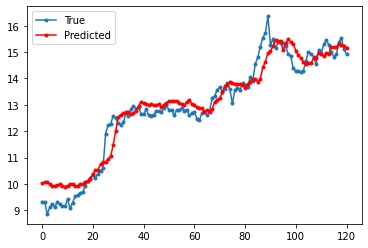

In [12]:
plt.plot(y_test_inv.flatten(),marker='.',label='True')
plt.plot(pred.flatten(),'r',marker='.',label='Predicted')
plt.legend()
plt.show()